/var/folders/6d/7b4hj3sj02n7mkzyk8_2m3wc0000gn/T/ipykernel_28151/2276818254.py:15: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



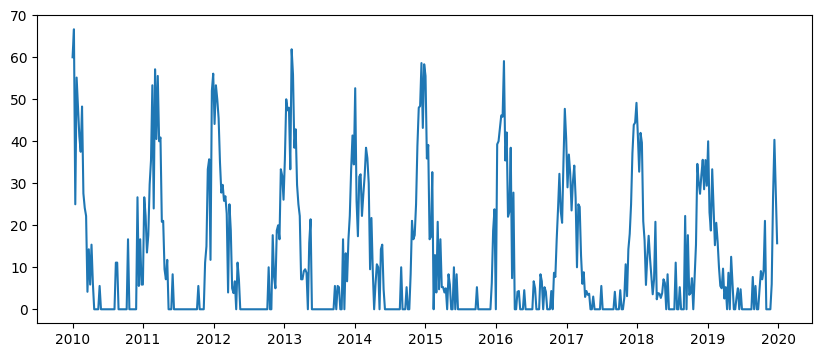

In [99]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from scipy.stats import boxcox
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from scipy.special import inv_boxcox

def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

data = pd.read_csv('Respiratory/Children_RSV_ARIMA.csv', parse_dates=[0], index_col=0, date_parser=parser)
data = data.asfreq(pd.infer_freq(data.index))
data['Week'] = pd.to_datetime(data['Children Under 5 RSV%'].index)
plt.figure(figsize=(10,4))
plt.plot(data['Week'], data['Children Under 5 RSV%'])

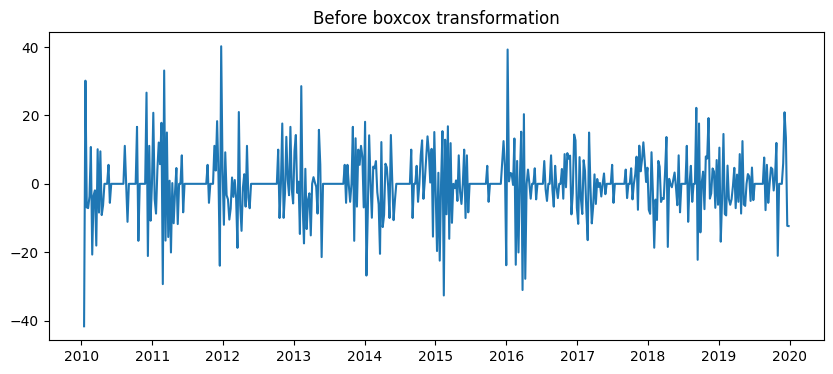

In [122]:
first_diff_before_boxcox = data['Children Under 5 RSV%'].diff()[1:]
plt.figure(figsize=(10,4))
plt.title("Before boxcox transformation")
plt.plot(first_diff_before_boxcox)

# the variance in the below plot is not too consistent, though the data is quite stationary
# applying the boxcox method will try to level out the variance and make the data even more stationary

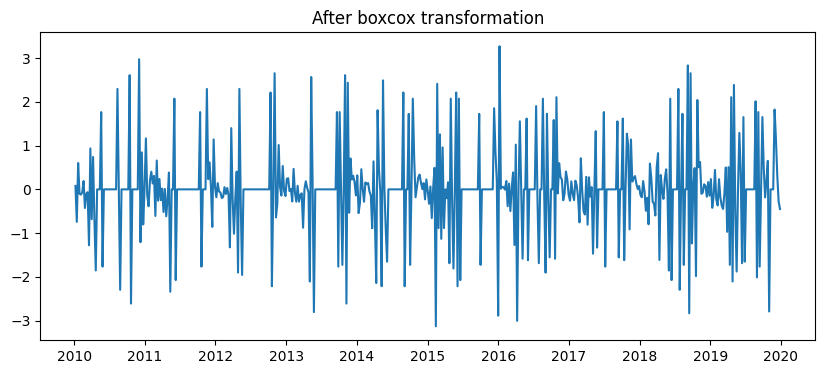

In [101]:
data['boxcox_rates'], lam = boxcox(data["Children Under 5 RSV%"] + 1)
data['diff_rates'] = data['boxcox_rates'].diff()
data.dropna(inplace=True)

plt.figure(figsize=(10,4))
plt.title("After boxcox transformation") # the variance is more consistent now
plt.plot(data['diff_rates'])

In [102]:
#ADF test to check how stationary the data is
def adf_test(series):
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))


adf_test(data["Children Under 5 RSV%"][1:])

ADF Statistic:  -6.572771239059014
P-Value:  7.860356934681028e-09
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


In [103]:
# As we can see from the above, the data itself is stationary with between 99-100% confidence
# Doing the ADF test on the differenced data is even more confident, but the data itself should be sufficient

# ADF test on first difference before boxcox transformation
adf_test(first_diff_before_boxcox)

ADF Statistic:  -8.718730038611522
P-Value:  3.431430021907413e-14
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


In [104]:
# ADF test on first difference after boxcox transformation results an even higher confidence in stationarity
adf_test(data['diff_rates'])

ADF Statistic:  -19.049499441679373
P-Value:  0.0
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


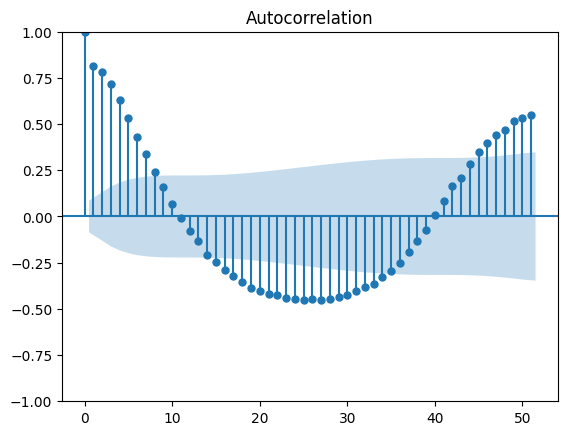

In [105]:
# ACF test to find lags for moving average step- the first lag looks appropriate as it has the best correlation
plot_acf(data["Children Under 5 RSV%"], lags=np.arange(52))
plt.show()

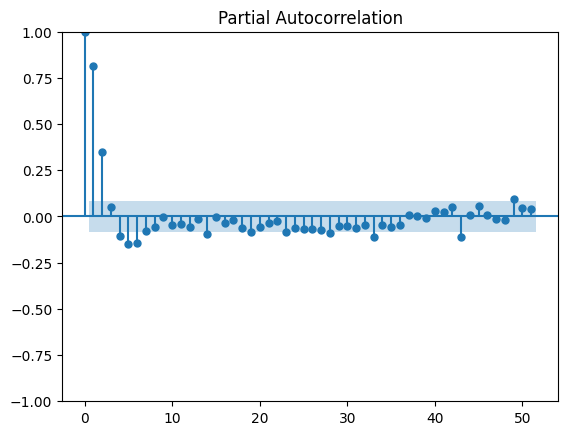

In [106]:
# PACF test to find lags for auto regression step- the first lag looks appropriate
plot_pacf(data["Children Under 5 RSV%"], lags=np.arange(52))
plt.show()

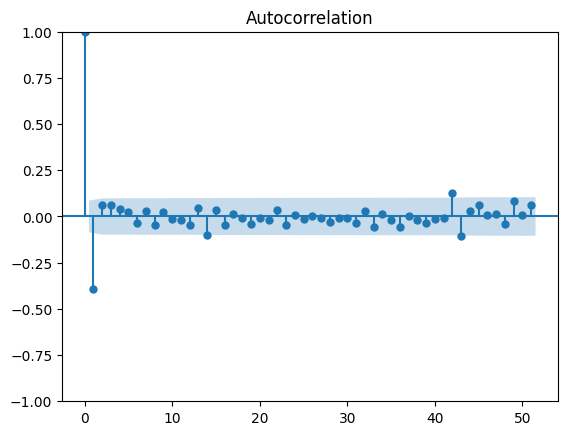

In [107]:
# ACF test on the differenced data
plot_acf(first_diff_before_boxcox,lags=np.arange(52))
plt.show()

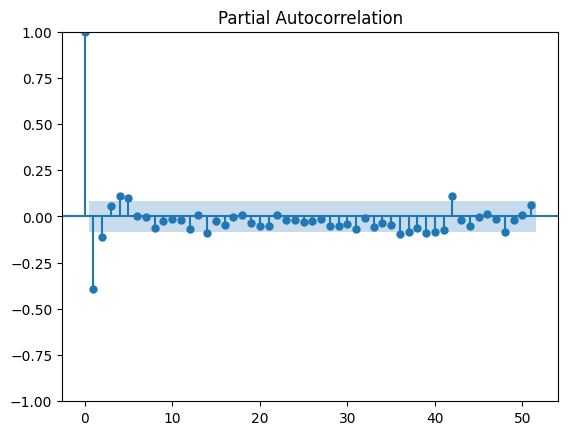

In [108]:
# PACF on the differenced data
plot_pacf(first_diff_before_boxcox,lags=np.arange(52))
plt.show()

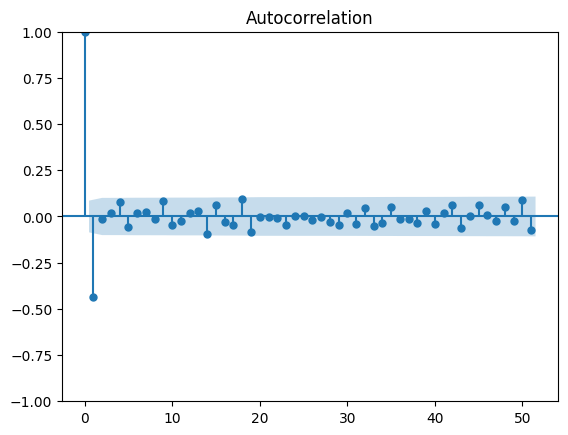

In [109]:
# ACF test on differenced + boxcox'd data
plot_acf(data['diff_rates'],lags=np.arange(52))
plt.show()

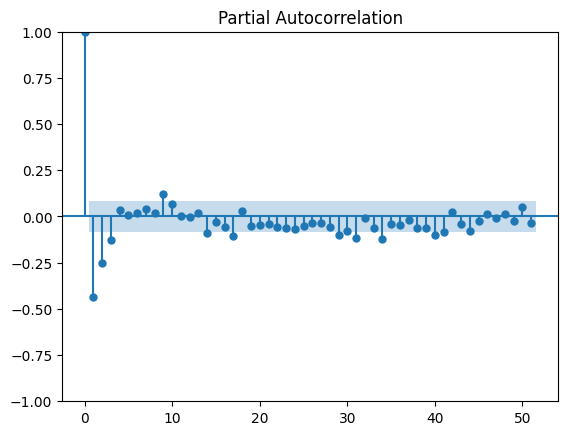

In [110]:
# PACF test on differenced + boxcox'd data
plot_pacf(data['diff_rates'],lags=np.arange(52))
plt.show()

After running ACF and PACF on the differenced + boxcox'd data, we can more confidently use the first lag for the auto-regression and moving average components of ARIMA

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25373D+00    |proj g|=  8.14757D-02


 This problem is unconstrained.



At iterate    5    f=  3.18627D+00    |proj g|=  2.66559D-02

At iterate   10    f=  3.15021D+00    |proj g|=  1.08849D-02

At iterate   15    f=  3.15000D+00    |proj g|=  1.07548D-03

At iterate   20    f=  3.14984D+00    |proj g|=  1.23232D-03

At iterate   25    f=  3.14981D+00    |proj g|=  2.15822D-04

At iterate   30    f=  3.14981D+00    |proj g|=  8.58068D-05

At iterate   35    f=  3.14981D+00    |proj g|=  8.69810D-05

At iterate   40    f=  3.14981D+00    |proj g|=  3.85426D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     50      1     0     0   2.491D-05   3.150D+00
  F =   3.14980734791

/opt/homebrew/Cellar/jupyterlab/4.2.3/libexec/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



<Axes: xlabel='Week'>

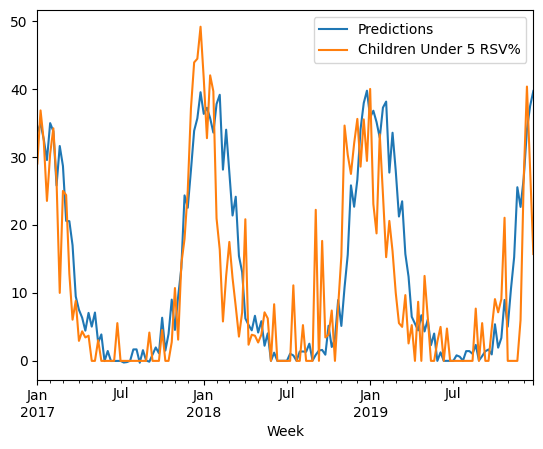

In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

train = data.iloc[:len(data)-52*3] 
test = data.iloc[len(data)-52*3:] # set one year(12 months) for testing 

model = SARIMAX(train["Children Under 5 RSV%"], 
				order = (1, 0, 1), 
				seasonal_order =(1, 1, 1, 52)).fit() 
#model.summary()
start = len(train) 
end = len(train) + len(test) - 1
  
predictions = model.predict(start, end, typ = 'levels').rename("Predictions") 
  
predictions.plot(legend = True) 
test['Children Under 5 RSV%'].plot(legend = True)

In [112]:
#train_end = datetime(2017,1,1)
#test_end = datetime(2019,12,31)
#train = data[:train_end]
#test = data[train_end + timedelta(days=1):test_end]

model = ARIMA(train["Children Under 5 RSV%"], order=(1, 0, 1), seasonal_order=(1, 1, 1, 52)).fit()
forecasts = model.forecast(len(test))
print(model.summary())

                                    SARIMAX Results                                     
Dep. Variable:            Children Under 5 RSV%   No. Observations:                  365
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -1149.680
Date:                          Fri, 30 Aug 2024   AIC                           2309.359
Time:                                  19:12:32   BIC                           2328.090
Sample:                              01-08-2010   HQIC                          2316.845
                                   - 12-30-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8291      0.045     18.423      0.000       0.741       0.917
ma.L1         -0.4499      0.073     -6.122      0.

Text(0, 0.5, 'Percentage of Positive Tests')

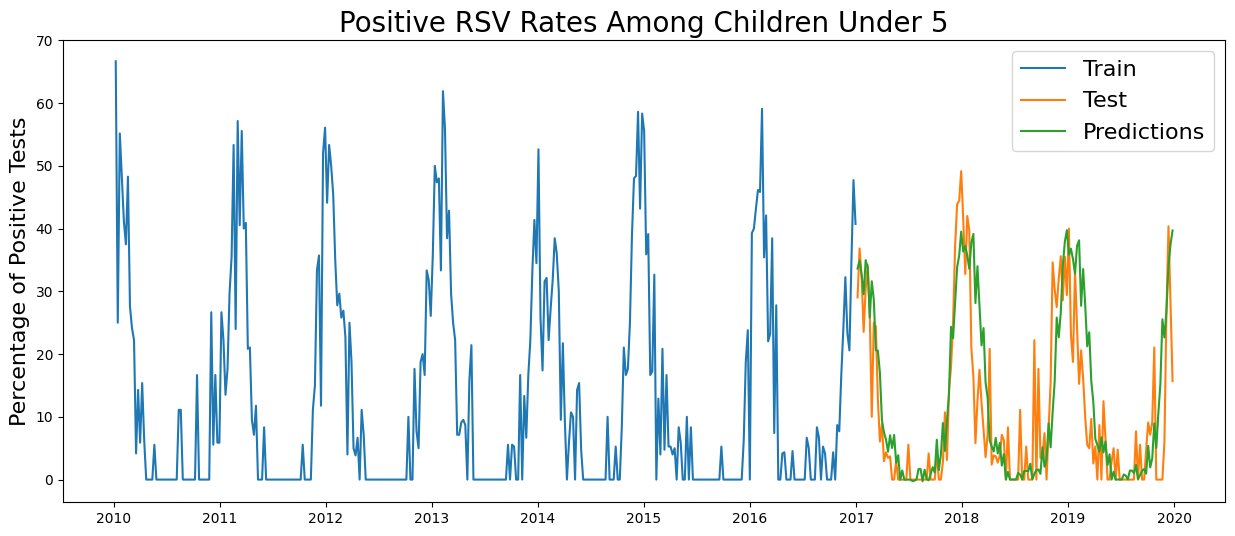

In [113]:
plt.figure(figsize=(15,6))
plt.plot(train['Children Under 5 RSV%'])
plt.plot(test['Children Under 5 RSV%'])
plt.plot(forecasts)
plt.legend(('Train', 'Test', 'Predictions'), fontsize=16)
plt.title('Positive RSV Rates Among Children Under 5', fontsize=20)
plt.ylabel('Percentage of Positive Tests', fontsize=16)

Text(0, 0.5, 'Percentage of Positive Tests')

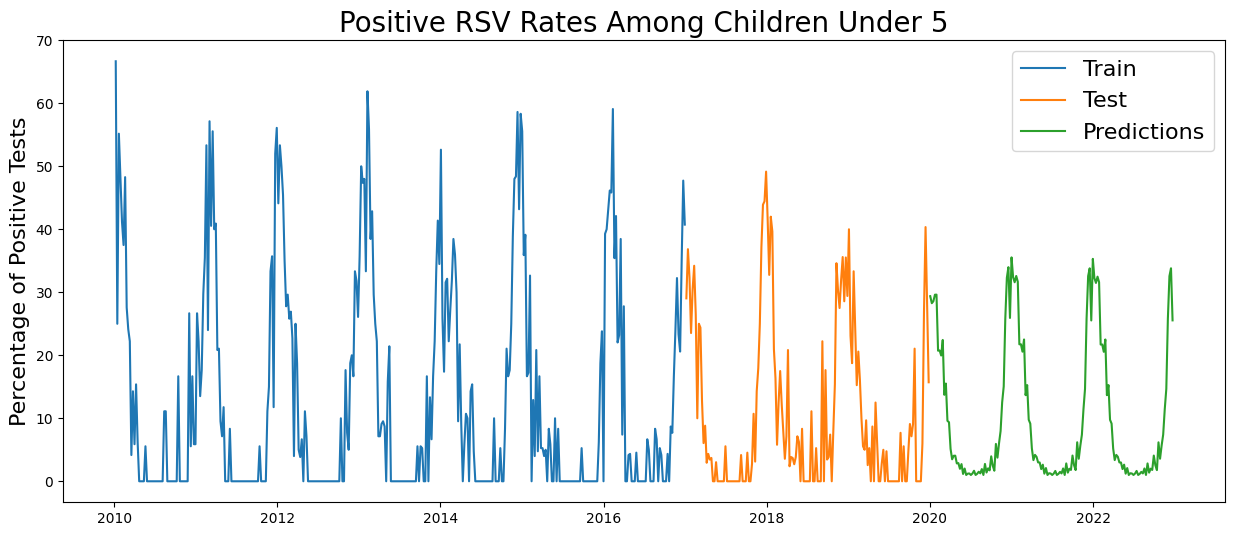

In [114]:
# predictions by inversing the boxcox method
boxcox_model = ARIMA(data['boxcox_rates'], order=(1, 0, 1),
              seasonal_order=(1, 1, 1, 52)).fit()
boxcox_forecasts = boxcox_model.forecast(len(test))
inv_boxcox_forecasts = inv_boxcox(boxcox_forecasts, lam)

plt.figure(figsize=(15,6))
plt.plot(train['Children Under 5 RSV%'])
plt.plot(test['Children Under 5 RSV%'])
plt.plot(inv_boxcox_forecasts)
plt.legend(('Train', 'Test', 'Predictions'), fontsize=16)
plt.title('Positive RSV Rates Among Children Under 5', fontsize=20)
plt.ylabel('Percentage of Positive Tests', fontsize=16)

RSV rates among the elderly:

/var/folders/6d/7b4hj3sj02n7mkzyk8_2m3wc0000gn/T/ipykernel_28151/3936525524.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



                                    SARIMAX Results                                     
Dep. Variable:             Adults Over 65 RSV %   No. Observations:                  365
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -857.653
Date:                          Fri, 30 Aug 2024   AIC                           1725.305
Time:                                  19:12:39   BIC                           1744.036
Sample:                              01-08-2010   HQIC                          1732.790
                                   - 12-30-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8152      0.070     11.568      0.000       0.677       0.953
ma.L1         -0.6137      0.097     -6.332      0.

Text(0, 0.5, 'Percentage of Positive Tests')

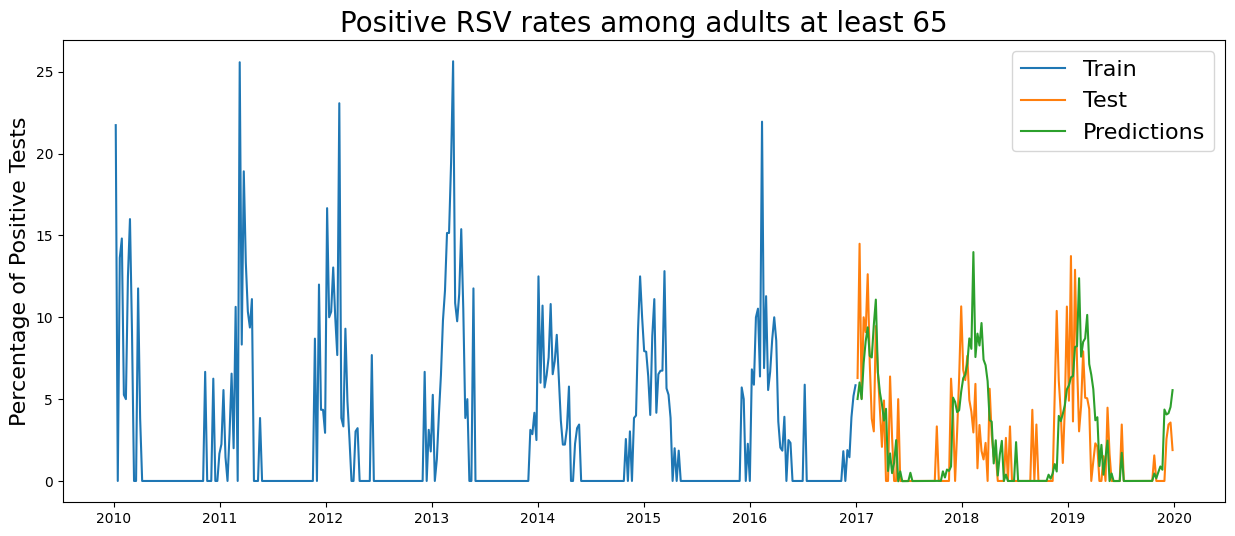

In [115]:
dataa = pd.read_csv('Respiratory/Elders_RSV_ARIMA.csv', parse_dates=[0], index_col=0, date_parser=parser)
dataa = dataa.asfreq(pd.infer_freq(dataa.index))

dataa['boxcox_rates'], lam = boxcox(dataa["Adults Over 65 RSV %"] + 1)
dataa['diff_rates'] = dataa['boxcox_rates'].diff()
dataa.dropna(inplace=True)

#first_diffa = dataa.diff()[1:]
#plt.figure(figsize=(10,4))
#plt.plot(first_diffa)

# running the ADF test on the data and first_diffa shows they're both very stationary

#plot_acf(first_diffa,lags=np.arange(52))
#plot_pacf(first_diffa,lags=np.arange(52))

traina = dataa[:train_end]
testa = dataa[train_end + timedelta(days=1):test_end]

modela = ARIMA(traina["Adults Over 65 RSV %"], order=(1, 0, 1),
              seasonal_order=(1, 1, 1, 52)).fit()
forecastsa = modela.forecast(len(testa))
print(modela.summary())

plt.figure(figsize=(15,6))
plt.plot(traina["Adults Over 65 RSV %"])
plt.plot(testa["Adults Over 65 RSV %"])
plt.plot(forecastsa)
plt.legend(('Train', 'Test', 'Predictions'), fontsize=16)
plt.title('Positive RSV rates among adults at least 65', fontsize=20)
plt.ylabel('Percentage of Positive Tests', fontsize=16)

Text(0, 0.5, 'Percentage of Positive Tests')

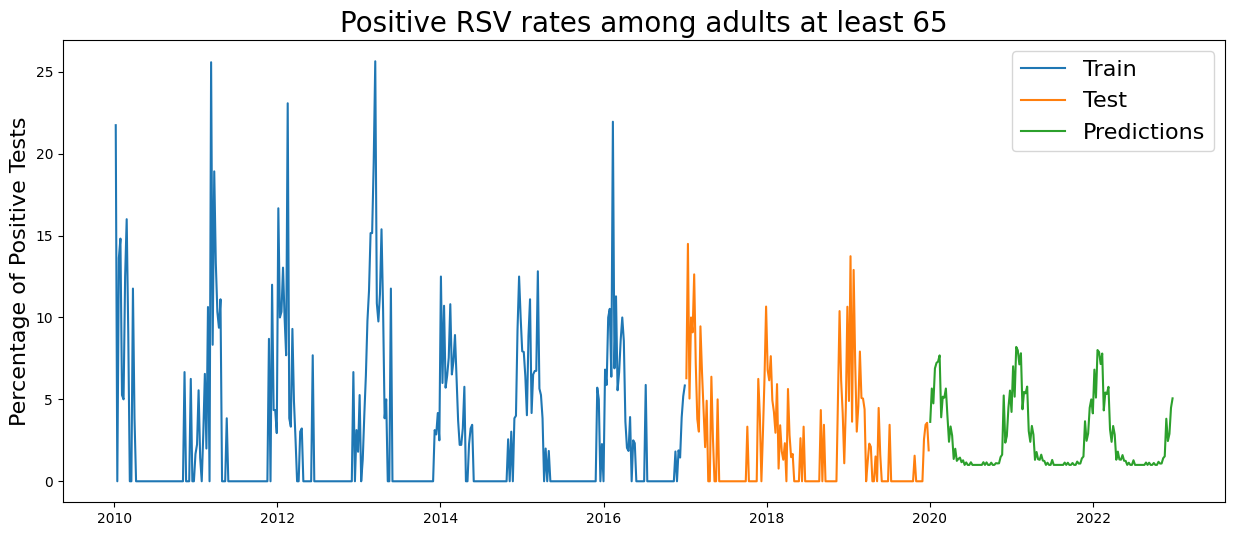

In [116]:
# predictions by inversing the boxcox method
boxcox_modela = ARIMA(dataa['boxcox_rates'], order=(1, 0, 1),
              seasonal_order=(1, 1, 1, 52)).fit()
boxcox_forecastsa = boxcox_modela.forecast(len(test))
inv_boxcox_forecastsa = inv_boxcox(boxcox_forecastsa, lam)

plt.figure(figsize=(15,6))
plt.plot(traina["Adults Over 65 RSV %"])
plt.plot(testa["Adults Over 65 RSV %"])
plt.plot(inv_boxcox_forecastsa)
plt.legend(('Train', 'Test', 'Predictions'), fontsize=16)
plt.title('Positive RSV rates among adults at least 65', fontsize=20)
plt.ylabel('Percentage of Positive Tests', fontsize=16)

Now if we plot both forecasts together:

Text(0, 0.5, 'Percentage of Positive Tests')

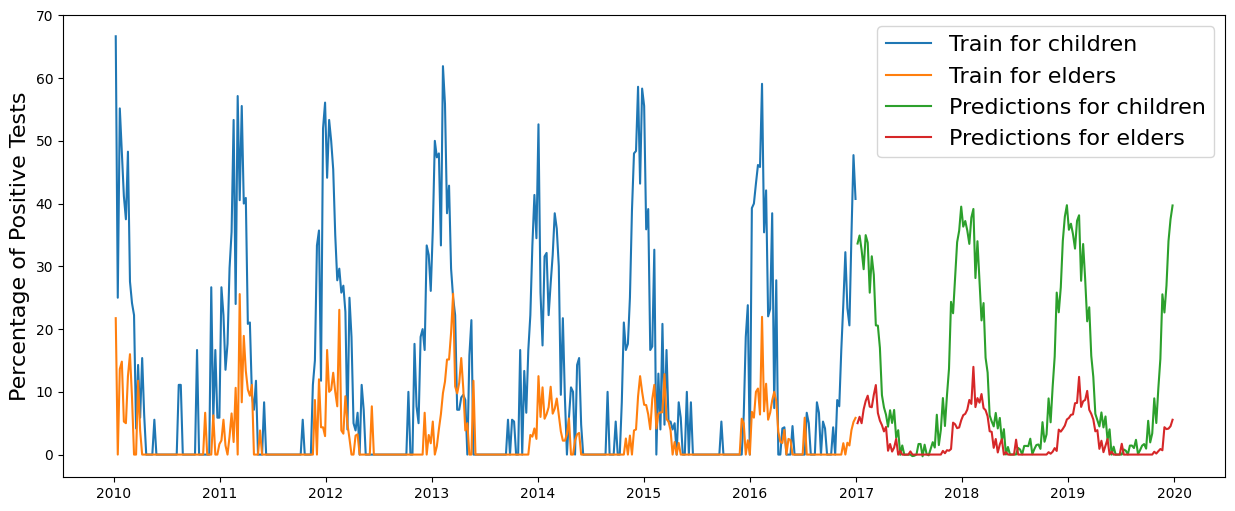

In [121]:
plt.figure(figsize=(15,6))
plt.plot(train['Children Under 5 RSV%'])
plt.plot(traina["Adults Over 65 RSV %"])
plt.plot(forecasts)
plt.plot(forecastsa)
plt.legend(('Train for children', 'Train for elders', 'Predictions for children', 'Predictions for elders'), fontsize=16)
plt.ylabel('Percentage of Positive Tests', fontsize=16)

Text(0, 0.5, 'Percentage of Positive Tests')

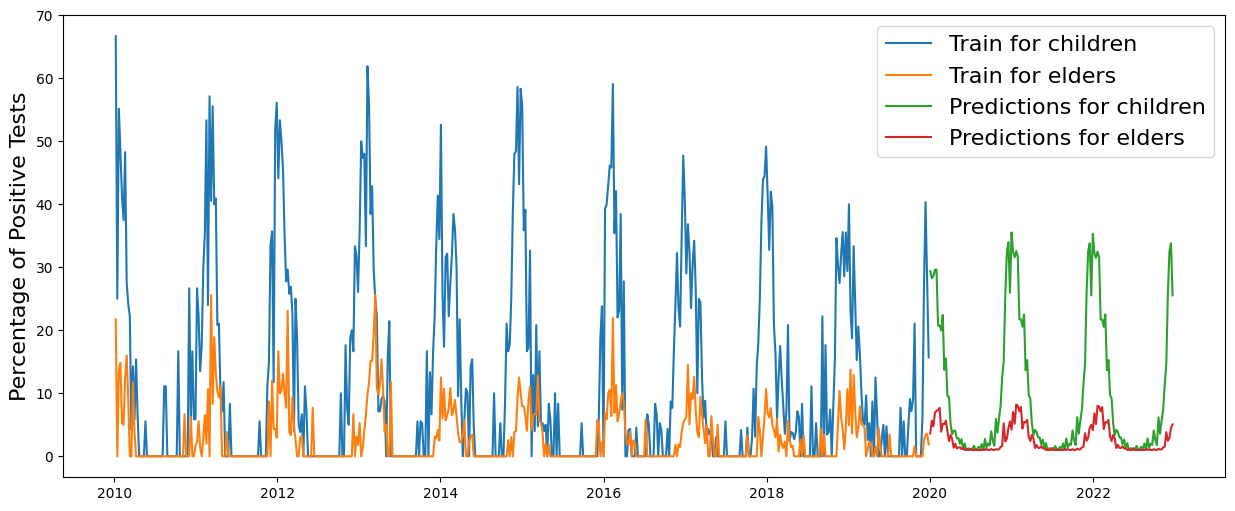

In [120]:
# predictions with boxcox method
plt.figure(figsize=(15,6))
plt.plot(data['Children Under 5 RSV%'])
plt.plot(dataa["Adults Over 65 RSV %"])
plt.plot(inv_boxcox_forecasts)
plt.plot(inv_boxcox_forecastsa)
plt.legend(('Train for children', 'Train for elders', 'Predictions for children', 'Predictions for elders'), fontsize=16)
plt.ylabel('Percentage of Positive Tests', fontsize=16)

The latter portion of the above graph shows the predictions of positive weekly rates for children vs. the predictions of positive weekly rates for adults. The predictions indicate that children hit a sustained rise in weekly positive tests well before the elderly do. Thus, we can take preventive measures by vaccinating the elderly and children as soon as we see the RSV positivity rates among children rise.